---
title: Voice Emotion Classification
author: Catie Baxter and Otis Milliken 
date: '2024-04-07'
description: "Final Project for CS0451"
format: html
---

Here is a link to the [dataset](https://zenodo.org/records/1188976#.XrC7a5NKjOR) with used.

The files in our dataset were named using a specific naming structure by the original authors. Each file has a unique filename that act as identifiers for the characteristics of the audio file.

There are 7 digits, divided by dashes (e.g. "02-01-06-01-02-01-12.mp4"). 

The first digit reflects the **modality**:
    01 - full-AV
    02 - video only
    03 - audio-only

The second digit is the vocal channel. We are only investigating the speech files so they will all be 01.

The third digit is the **emotion** which will be our target variable.
    01 - neutral
    02 - calm
    03 - happy
    04 - sad
    05 - angry
    06 - fearful
    07 - disgust
    08 - surprised

The fourth digit reflects the emotional intensity, which is 01 for normal and 02 for strong.

The fifth digit reflects the **statement** in the file:
    01 - "Kids are talking by the door"
    02 - "Dogs are sitting by the door"

The sixth digit indicates the repetition number of the study: 01 or 02.

Finally the seventh digit is the actor that spoke in the recording, labelled 01 to 24. Odd numbers are male and even numbers are female. 


In [16]:
import os
import pandas as pd
import librosa
import numpy as np
import torch

# assign directory

directory = "data"

dictionary = {
    'Filepath': [],
    'Modality': [],
    'Vocal_channel': [],
    'Emotion':[],
    'Emotional_intensity':[],
    'Statement':[],
    'Repetition':[],
    'Actor':[],
    'Sample':[],
    'Sample_rate': [],
    'Sex':[],
    'Mel_sgram': []
}

def parse_filename(file):
    filename = file[5:-4]
    digits = filename.split("-")
    dictionary['Modality'].append(digits[0])
    dictionary['Vocal_channel'].append(digits[1])
    dictionary['Emotion'].append(int(digits[2]))
    dictionary['Emotional_intensity'].append(digits[3])
    dictionary['Statement'].append(digits[4])
    dictionary['Repetition'].append(digits[5])
    dictionary['Actor'].append(digits[6])
    dictionary['Sex'].append('Female' if (int(digits[6]) % 2) == 0 else 'Male') # odd numbers are male (1), even numbers female (0)
    return 

def create_sgram(sample, sr):
    max_length = 228
    sgram = librosa.stft(sample)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=0)
    # add padding
    mel_sgram_padded = np.pad(mel_sgram, ((0, 0), (max_length - len(mel_sgram), 0)), mode='constant')
    return mel_sgram_padded

def getting_files(directory):
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename) 
        if os.path.isfile(file):
            dictionary['Filepath'].append(file)
            samples, samplerate = librosa.load(file)
            dictionary['Sample'].append(samples)
            dictionary['Sample_rate'].append(samplerate)
            dictionary['Mel_sgram'].append(create_sgram(samples, samplerate))
            parse_filename(file)

getting_files(directory)

df = pd.DataFrame(dictionary)

0       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                              ...                        
1435    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1436    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1437    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1438    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1439    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: Mel_sgram, Length: 1440, dtype: object


In [19]:
print(df['Mel_sgram'][2])

[[ 0.        0.        0.       ... 14.906624 14.906624 14.906624]
 [ 0.        0.        0.       ... 14.906624 14.906624 14.906624]
 [ 0.        0.        0.       ... 19.437523 14.906624 14.906624]
 ...
 [ 0.        0.        0.       ... 14.906624 14.906624 14.906624]
 [ 0.        0.        0.       ... 14.906624 14.906624 14.906624]
 [ 0.        0.        0.       ... 14.906624 14.906624 14.906624]]


## Split up our Data

In the next step we split up our data

In [21]:
from sklearn.model_selection import train_test_split

data = df[["Mel_sgram", "Emotion"]]

df_train, df_test = train_test_split(data, test_size = 0.2, random_state = 123)

In [61]:
X_train = df_train["Mel_sgram"]
y_train = df_train["Emotion"]

X_test = df_test["Mel_sgram"]
y_test = df_test["Emotion"]

In [62]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [25]:
## Divide Data into Testing and Training
# import numpy as np
# from numpy import random

# # Split the data so that 50% is used for training, and 50% is used for testing

# n, p = df.shape[0], df.shape[1] 
# #random_test_index = np.random.randint(0, high=n, size=int(n/2))

# test_subset = df.sample(frac = 0.3)

# # Testing Subset
# y_test = test_subset.drop(columns=["Modality", "Vocal_channel", "Emotional_intensity", "Statement", "Repetition", "Actor", "Sex", "Sample", "Sample_rate", "Mel_sgram"])
# X_test = test_subset.drop(columns=["Emotion"])

# # Training Subset
# train_subset = df.drop(test_subset.index)
# print(train_subset.head())

# y_train = train_subset.drop(columns=["Modality", "Vocal_channel", "Emotional_intensity", "Statement", "Repetition", "Actor", "Sex", "Sample", "Sample_rate", "Mel_sgram"])
# X_train = train_subset.drop(columns=["Emotion"])
  
# print(f'y_train: {y_train.shape}, X_train: {X_train.shape}, y_test: {y_test.shape}, X_test: {X_test.shape}')

# y_train.head()


KeyError: 0

In [65]:
SAMPLE_RATE = df["Sample_rate"][0]

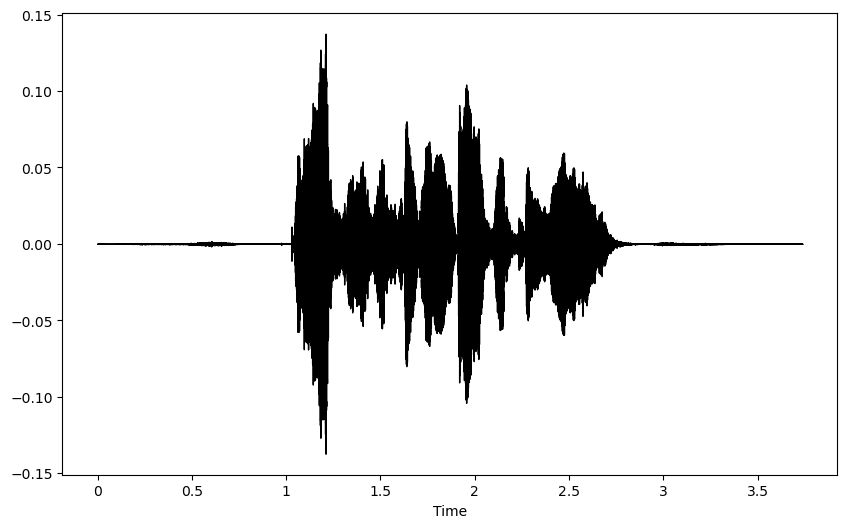

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
librosa.display.waveshow(df["Sample"][0], sr=SAMPLE_RATE, color="black")

## Creating Mel Spectogram

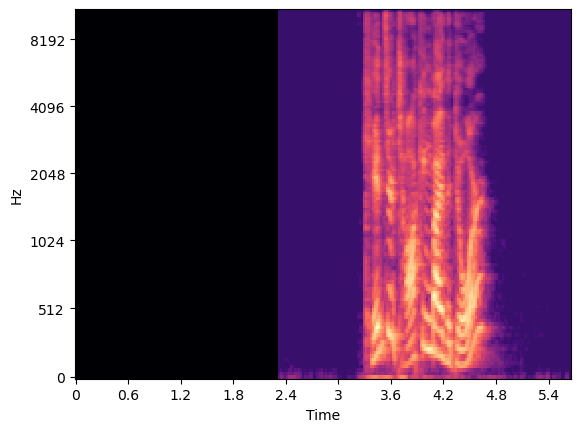

In [67]:
librosa.display.specshow(X_train[0], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')

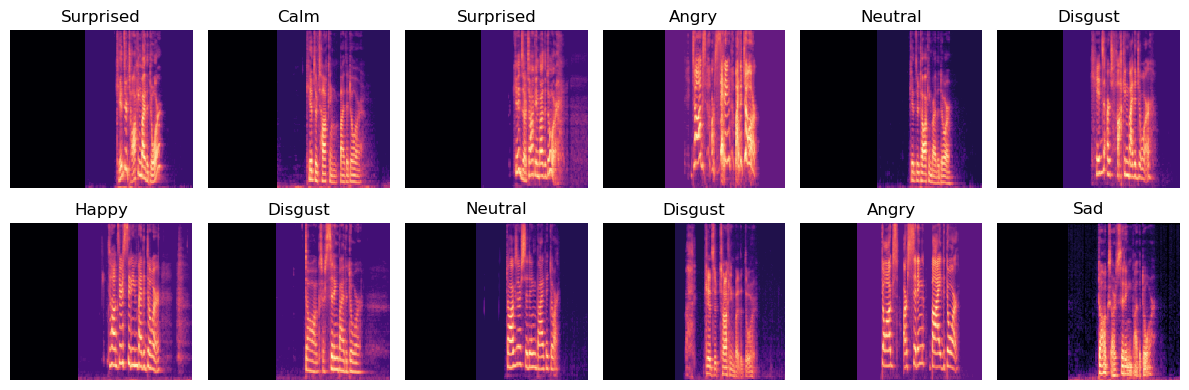

In [72]:
from matplotlib import pyplot as plt
EMOTIONS = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

def show_images(X, y, rows, cols):
    fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
    for i, ax in enumerate(axarr.ravel()):
        librosa.display.specshow(X[i], sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=ax)
        ax.set(title = f"{EMOTIONS[y[i]-1]}")
        ax.axis("off")
    plt.tight_layout()

show_images(X_train, y_train, 2, 6)